<a href="https://colab.research.google.com/github/ZKisielewska/learning-git-task/blob/master/M_15_5_Pipeline_campering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Select a dataset from those used in the regression or classification module. For one of these sets, create a **Pipeline** in which you will include the data preparation process and teach the new model by **comparing** it with those created in those modules.

We will use the **penguins.csv** [download](https://uploads.kodilla.com/bootcamp/ds/14/penguins.csv) dataset, which contains features for different species of penguins. We will build Pipeline for this dataset.

In [33]:
# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# split of data into training/validation/test sets
from sklearn.model_selection import train_test_split, GridSearchCV

# creating Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# dimensionality reduction
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [34]:
# download 'penquins' data
penguins = pd.read_csv('https://uploads.kodilla.com/bootcamp/ds/14/penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [35]:
# split the data int training and test sets
X = penguins.drop(['Species'] , axis=1).copy()
y = penguins['Species'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
num_features = ['CulmenLength' , 'CulmenDepth' , 'FlipperLength' , 'BodyMass']

In [36]:
# preparation of numeric values
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])
# transformer
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', LogisticRegression(max_iter=10000))])

In [37]:
# function that calculates metrics and shows plots
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_name = []
prediction_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
  models.append(model)
  models_name.append(name)
  global metrics_dataframe
  predictions = model.predict(X_checked)
  predictions_proba = model.predict_proba(X_checked)
  prediction_proba_list.append(predictions_proba[:, 1])

  # metrics for the model being checked
  print(classification_report(y_checked, predictions))

  # Confusion matrix
  plt.figure()
  cm = confusion_matrix(y_checked, predictions)
  ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
  ax.set_title('Confusion Matrix\n\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values')
  plt.show()

  # plot ROC curve
  fig = plt.figure(figsize=(6, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  for model_selected, name_selected, pred_proba in zip(models, models_name, prediction_proba_list):
    fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
    plt.plot(fpr, tpr, label=name_selected)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

  f1_metric = f1_score(y_checked, predictions, average='weighted')
  auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class='ovo')
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                               ignore_index=True)
  return metrics_dataframe

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



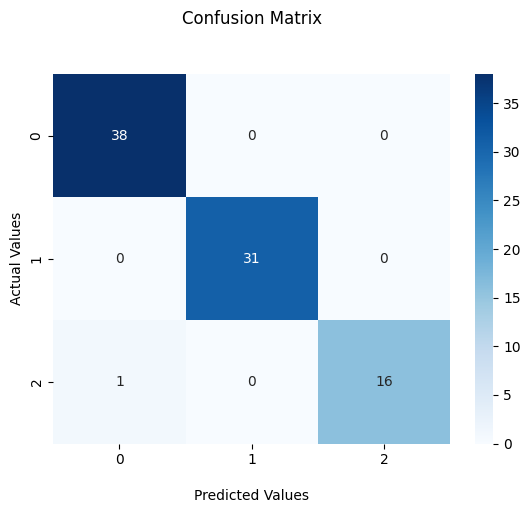

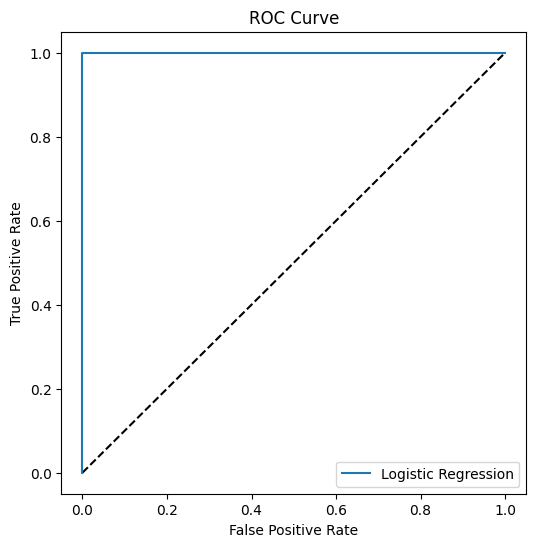

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.0


In [38]:
calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', KNeighborsClassifier(n_neighbors=3))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', KNeighborsClassifier(n_neighbors=3))])

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



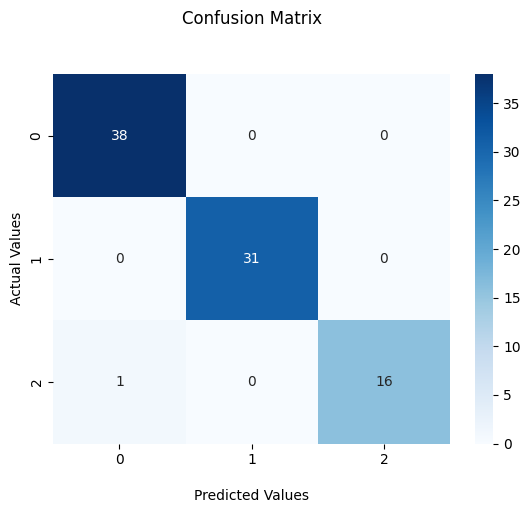

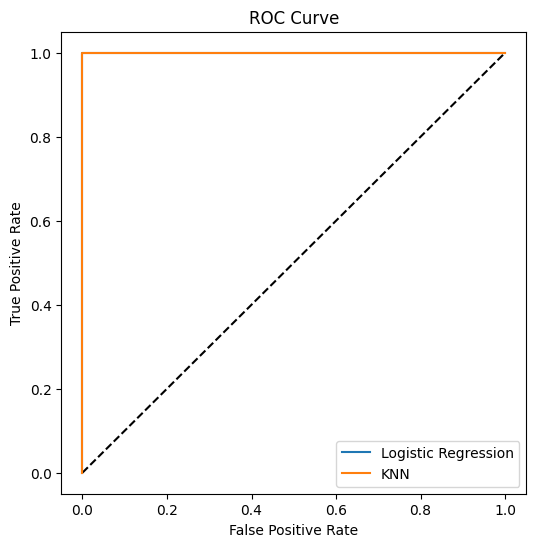

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.000000
1,KNN,0.988271,0.985036


In [40]:
calculate_metrics(model_pipeline_v2, 'KNN', X_test, y_test)

In [41]:
from sklearn.tree import DecisionTreeClassifier
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', DecisionTreeClassifier(max_depth=3, random_state=0))])
model_pipeline_v3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', DecisionTreeClassifier(max_depth=3, random_state=0))])

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        38
           1       0.91      1.00      0.95        31
           2       0.94      0.88      0.91        17

    accuracy                           0.94        86
   macro avg       0.94      0.93      0.94        86
weighted avg       0.94      0.94      0.94        86



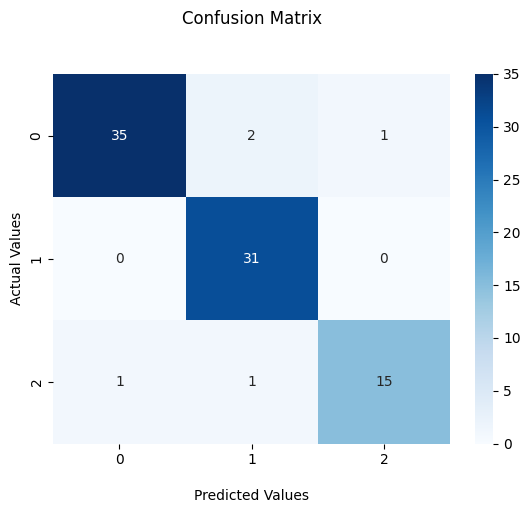

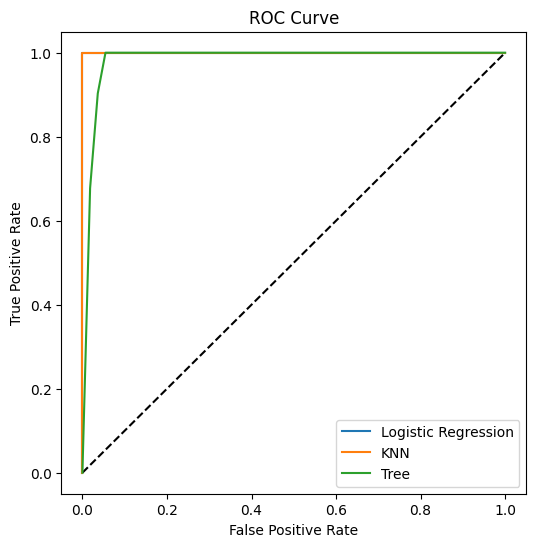

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.000000
1,KNN,0.988271,0.985036
2,Tree,0.941508,0.961458


In [42]:
calculate_metrics(model_pipeline_v3, 'Tree', X_test, y_test)

In [43]:
from sklearn.svm import SVC
model_pipeline_v4 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', SVC(kernel='rbf', probability=True))])
model_pipeline_v4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', SVC(probability=True))])

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      1.00      1.00        31
           2       1.00      0.94      0.97        17

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



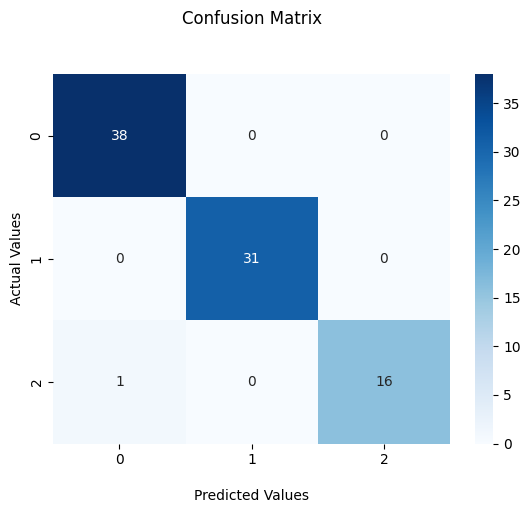

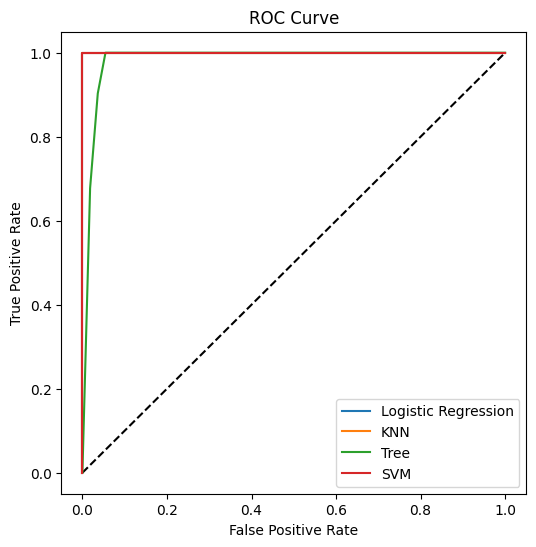

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.000000
1,KNN,0.988271,0.985036
2,Tree,0.941508,0.961458
3,SVM,0.988271,1.000000


In [44]:
calculate_metrics(model_pipeline_v4, 'SVM', X_test, y_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier
model_pipeline_v5 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', RandomForestClassifier())])
model_pipeline_v5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       0.94      1.00      0.97        31
           2       1.00      0.82      0.90        17

    accuracy                           0.97        86
   macro avg       0.97      0.94      0.95        86
weighted avg       0.97      0.97      0.96        86



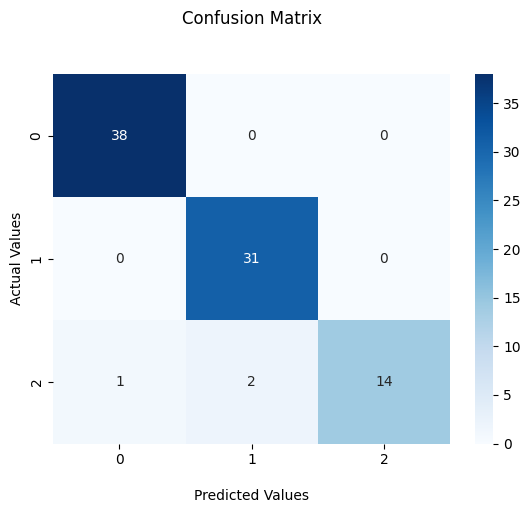

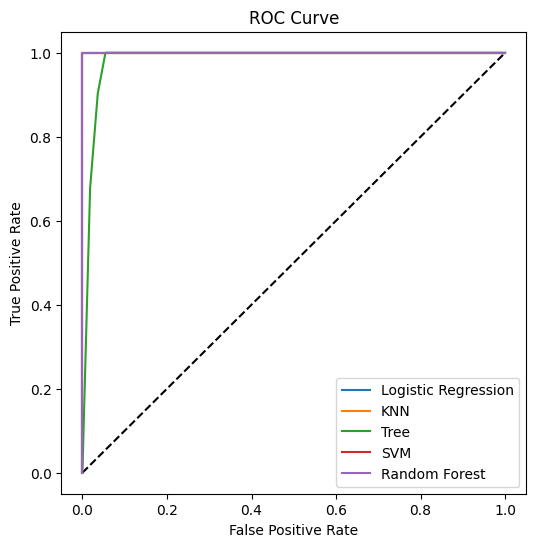

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.000000
1,KNN,0.988271,0.985036
2,Tree,0.941508,0.961458
3,SVM,0.988271,1.000000
4,Random Forest,0.963867,0.995493


In [46]:
calculate_metrics(model_pipeline_v5, 'Random Forest', X_test, y_test)

In [47]:
from sklearn.ensemble import AdaBoostClassifier
model_pipeline_v6 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50))])
model_pipeline_v6.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['CulmenLength',
                                                   'CulmenDepth',
                                                   'FlipperLength',
                                                   'BodyMass'])])),
                ('model',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)))])

              precision    recall  f1-score   support

           0       0.94      0.42      0.58        38
           1       0.53      0.90      0.67        31
           2       0.81      0.76      0.79        17

    accuracy                           0.66        86
   macro avg       0.76      0.70      0.68        86
weighted avg       0.77      0.66      0.65        86



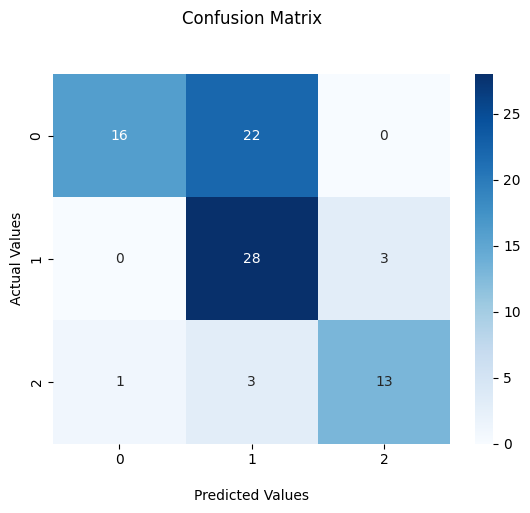

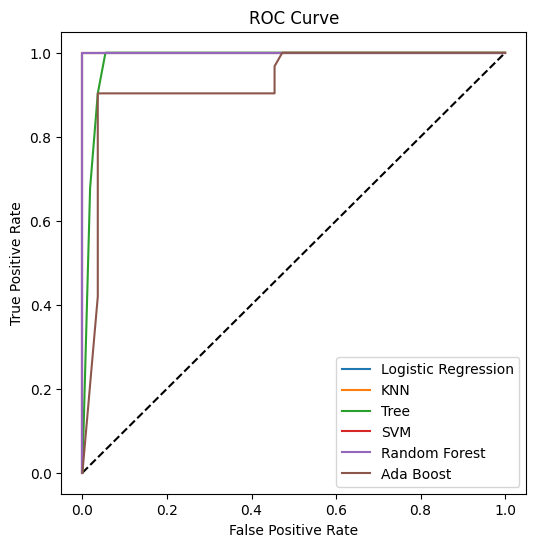

,Model,F1_score,AUC
0,Logistic Regression,0.988271,1.000000
1,KNN,0.988271,0.985036
2,Tree,0.941508,0.961458
3,SVM,0.988271,1.000000
4,Random Forest,0.963867,0.995493
5,Ada Boost,0.653136,0.937515


In [48]:
calculate_metrics(model_pipeline_v6, 'Ada Boost', X_test, y_test)

As we can see the models work very well apart from Tree and Ada Boost ones where Ada Boost generalize the worest results. Campering the models with those created in previous ones (Multiclass Classification) those two models also had the lowest results. Generally, Models created such a Pipeline generalize much better results, especially Logistic Regression and SVM models.